In [1]:
import sys
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0" #! specify gpu here
import numpy as np
from rich import print
import torch
import cv2
import matplotlib.pyplot as plt
from torch import optim, nn
import torchvision
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
import pytorch_lightning as pl
from torchmetrics.classification import BinaryAccuracy
import clip
import exp_utils as exp_utils
import albumentations as A
from data_loader import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from IPython.display import display

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model, preprocess = clip.load("ViT-B/32", device=device)

print("input resolution", model.visual.input_resolution)

# TODO: what does the CLIP encoder output?

seen_classes = ["hca_0", "hca_1", "hca_2", "hca_2a", "hca_3", "hca_4", "hca_5", "hca_6"]
unseen_classes = ["hca_7", "hca_8", "hca_9", "hca_10", "hca_11", "hca_11a", "hca_12"]

img_path = "datasets/2023-02-20_hca_backs"
preprocessing_path = "datasets/2023-02-20_hca_backs_preprocessing_opencv"

transform_resize = A.augmentations.geometric.resize.LongestMaxSize(max_size=224, always_apply=True)


val_transform = A.Compose([
        # transform_normalise,
        transform_resize,
        # ToTensorV2(),
    ])
train_transform = A.Compose([
        # transform_normalise,
        transform_resize,
        # ToTensorV2(),
    ])
                        
dl = DataLoader(img_path,
                        preprocessing_path=preprocessing_path,
                        batch_size=1,
                        seen_classes=seen_classes,
                        unseen_classes=unseen_classes,
                        train_transform=train_transform,
                        val_transform=val_transform,
                        cuda=True)


AttributeError: 'CLIP' object has no attribute 'input_resolution'

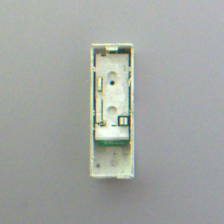

In [15]:
imgs, labels, path, detections = next(iter(dl.dataloaders["seen_train"]))

img = imgs[0] # first in batch
img_np = img.cpu().numpy()
img_pil = Image.fromarray(img_np)

display(img_pil)

In [18]:
features = []

for i, (imgs, labels, path, detections) in enumerate(dl.dataloaders["seen_train"]):
    for img in imgs:
        img_np = img.cpu().numpy()
        img_pil = Image.fromarray(img_np)

        # we have to use the CLIP preprocess
        img_pre = preprocess(img_pil).unsqueeze(0).to(device)

        image_features = model.encode_image(img_pre.to(device))
        features.append(image_features.cpu().detach().numpy())

features = np.array(features).squeeze()

print("features.shape", features.shape)

features.shape
(145, 512)

In [ ]:
# TODO: plot t-SNE. See plot_clip2.ipynb